In [103]:
import copy
import datetime
from datetime import date

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib.dates import DateFormatter

# NWIS API library
import dataretrieval.nwis as nwis

# Filesystem
import sys
sys.path.append("../../")

# ML library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from ipyleaflet import Map, Marker, Popup, basemaps, GeoData, MarkerCluster, FullScreenControl, LayersControl, basemap_to_tiles

In [3]:
np.random.seed(seed=1192)

In [114]:
PARAMETERS = ["00095","00060","00010","99133","00300"]
PARAMETER_NAMES = {
    '00095':'Specific conductance at 25 deg. C [microsiemens/cm]',
    '00300':'Dissolved oxygen [mg/L]',
    '99133':'Nitrate & nitrite [mg/L]',
    '00010':'Temperature [deg C]',
    '00060':'Discharge [ft^3/sec]'
}

RINGOLD_START_DATE = '2019-4-20'
KIONA_START_DATE = '2018-06-26'
END_DATE = date.today().strftime('%Y-%m-%d')

In [5]:
NOAA_DATA = pd.read_csv("noaa_station_data.csv")
NOAA_DATA = NOAA_DATA.set_index('DATE')
NOAA_DATA.rename(columns={"PRCP": "Precipitation [in.]"}, inplace = True)

In [105]:
# ringold_iv = nwis.get_record(sites="12473503",service="iv",parameterCd = PARAMETERS,start = RINGOLD_START_DATE,end = END_DATE)
# ringold_iv = nwis.get_record(sites="12510500",service="iv",parameterCd = PARAMETERS,start = KIONA_START_DATE,end = END_DATE)

%store - r ringold_iv
%store - r kiona_iv

Stored 'ringold_iv' (DataFrame)


In [132]:
def plotNWISdf(df, stationName):   
    # Copy raw dataframe
    record = copy.deepcopy(df)

    # Isolate the target parameters
    record = df[PARAMETERS]

    # Convert datestamp objects to datetime index (Austin's method)
    record.reset_index(inplace = True)
    record['datetime'] = pd.to_datetime(record['datetime'])
    record.set_index('datetime', inplace = True)

    # Remove all impossible values by setting to NaN
    record[record < 0] = np.nan

    # Prepare for plotting - rename values
    record.rename(columns = PARAMETER_NAMES, inplace = True)
    
    plot = record.plot(subplots = True, legend=False, figsize=(16,30), xlabel='Date', sharex=False, sharey=False)

    for i in range(len(plot)):
        plot[i].set_ylabel(record.columns[i])
        plot[i].set_title(stationName + " " + record.columns[i] + " vs. time")
    
    return (record, plot)

C:\Users\pierc\miniconda3\envs\my_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\pierc\AppData\Local\Temp/ipykernel_34912/1012579936.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record[record < 0] = np.nan
C:\Users\pierc\miniconda3\envs\my_env\lib\site-packages\pandas\core\frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

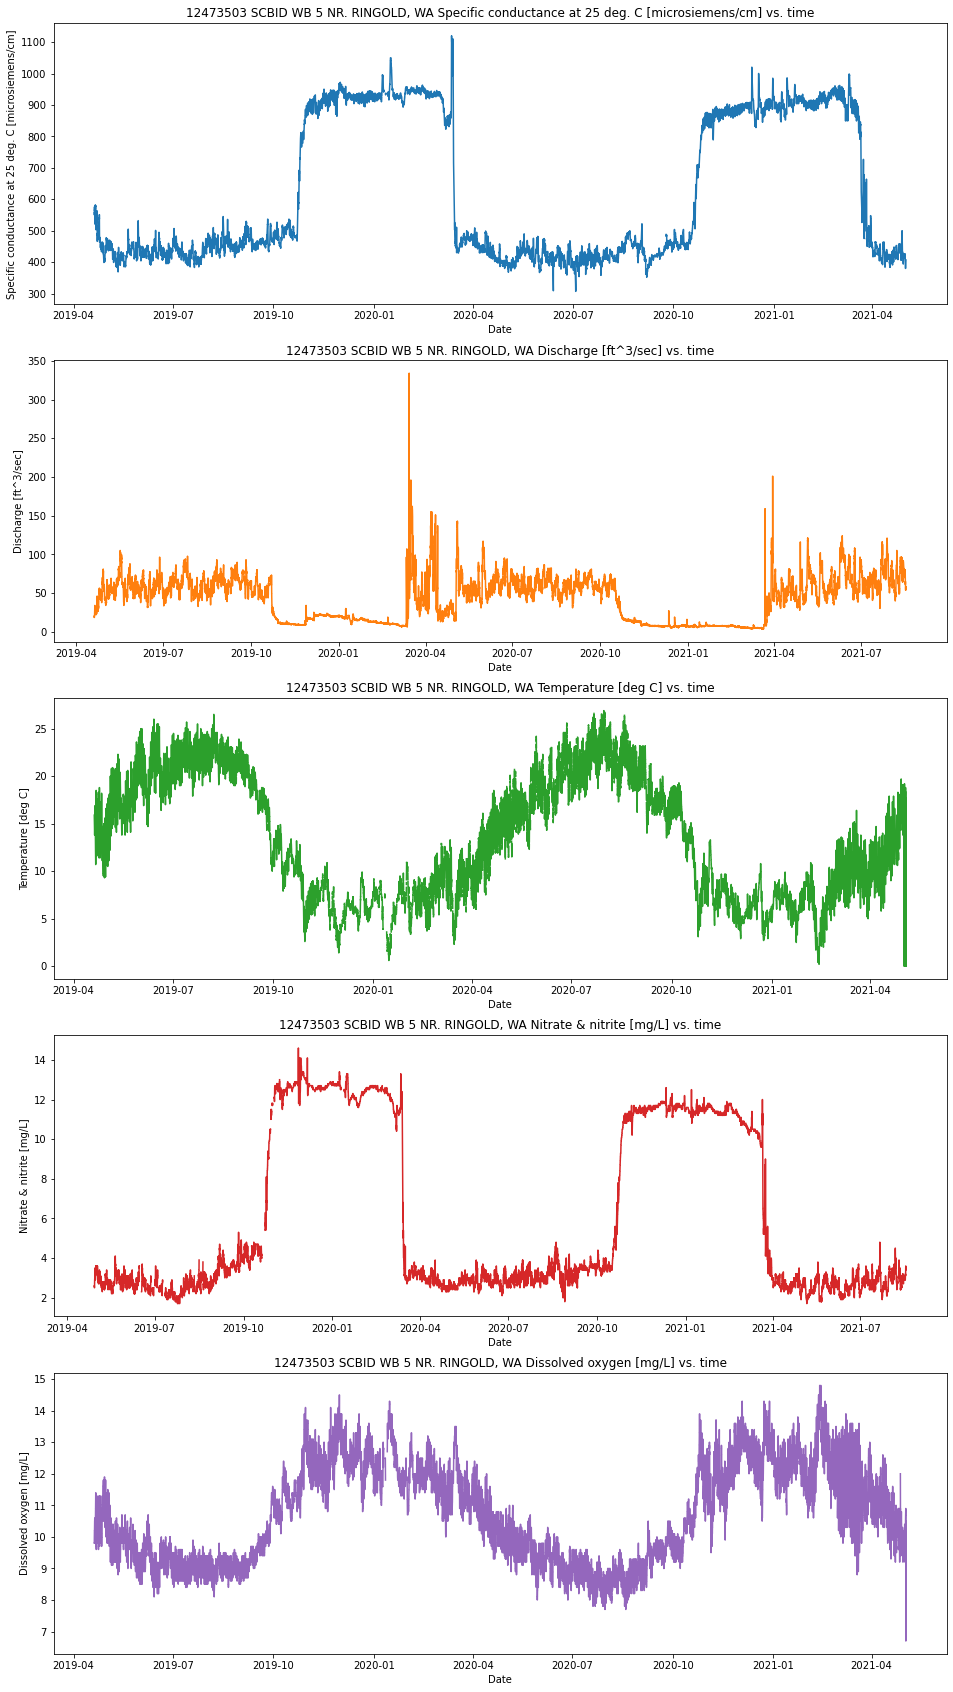

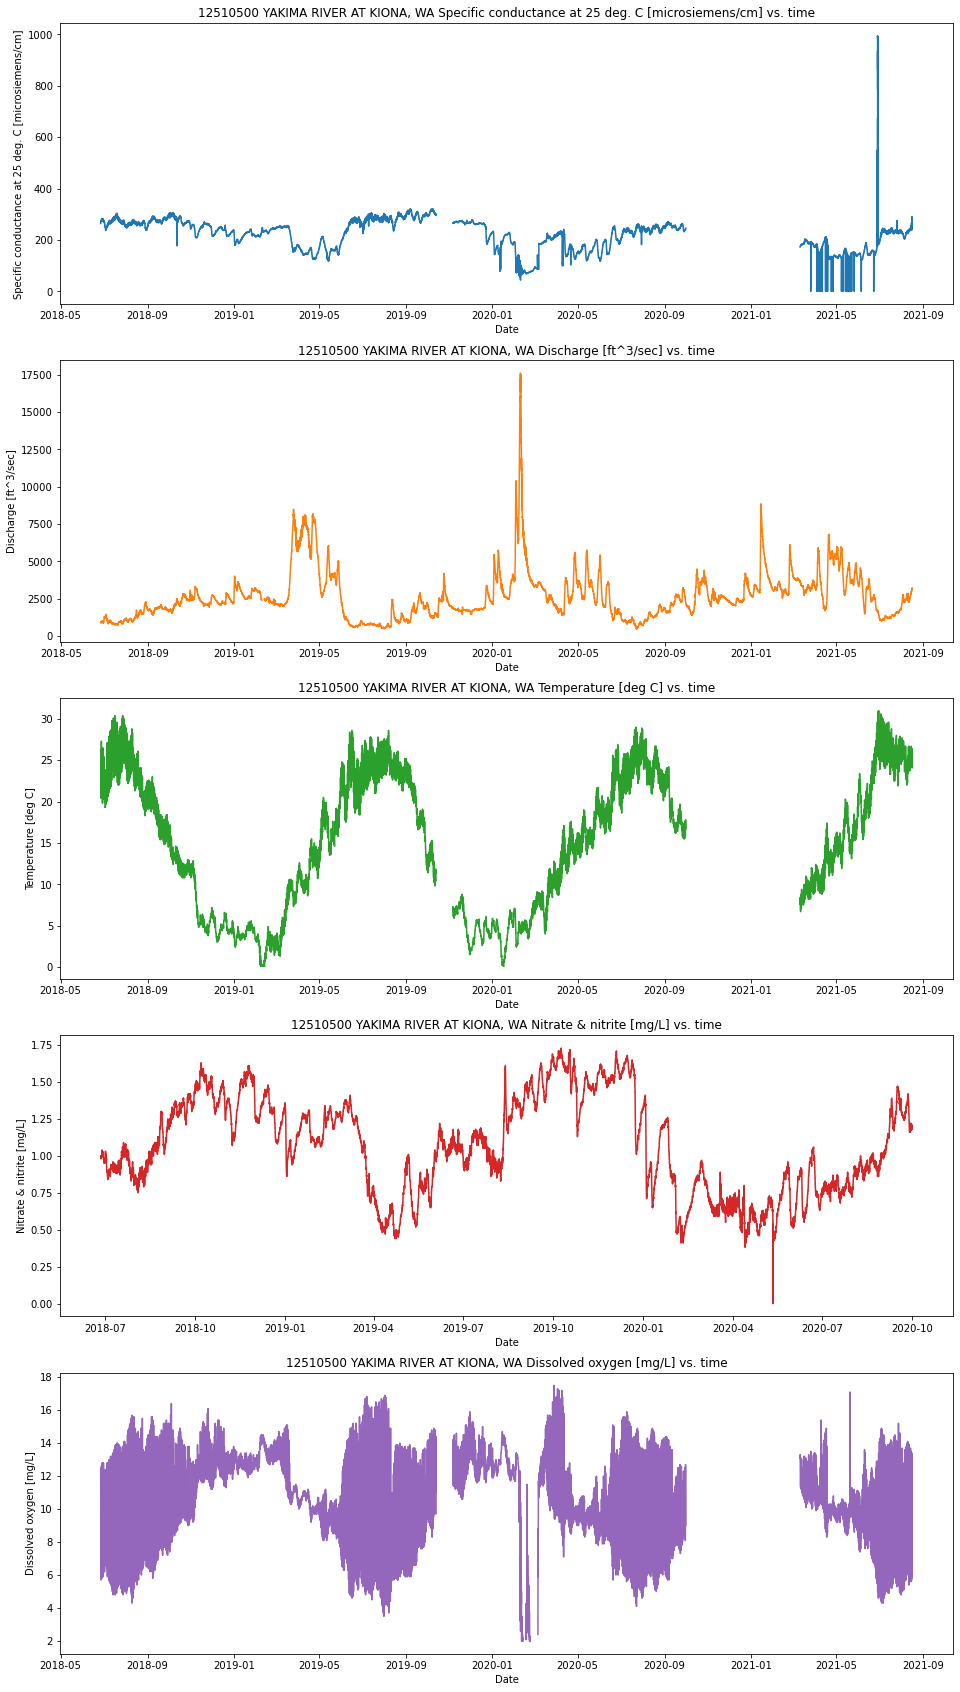

In [133]:
ringold_iv, ringold_plots = plotNWISdf(ringold_iv, "12473503 SCBID WB 5 NR. RINGOLD, WA")
kiona_iv, kiona_plots = plotNWISdf(kiona_iv, "12510500 YAKIMA RIVER AT KIONA, WA")

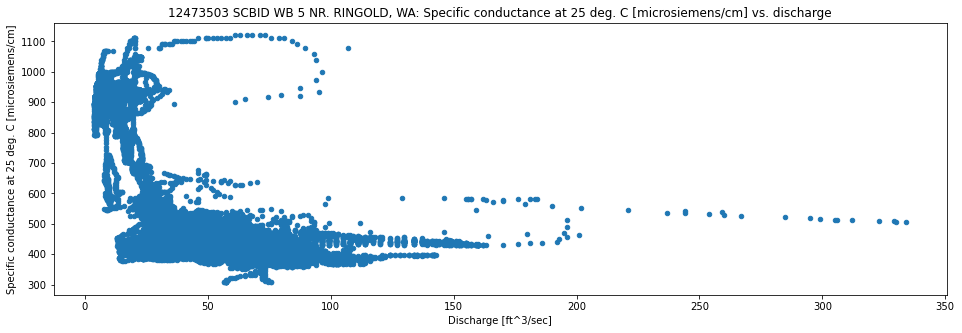

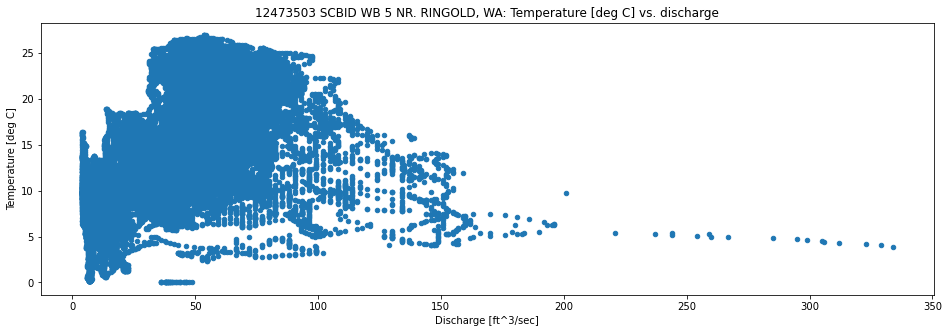

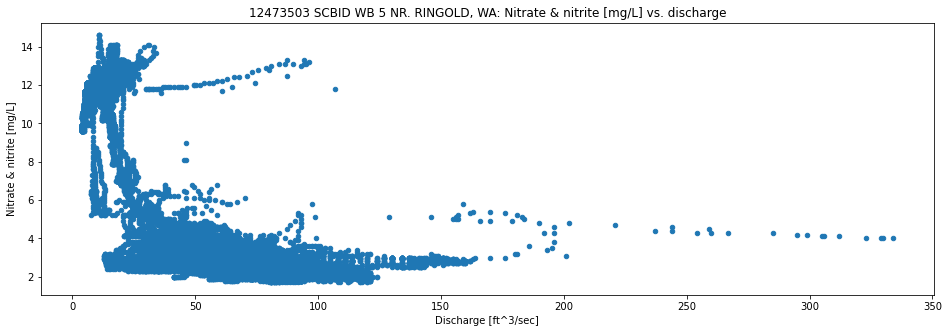

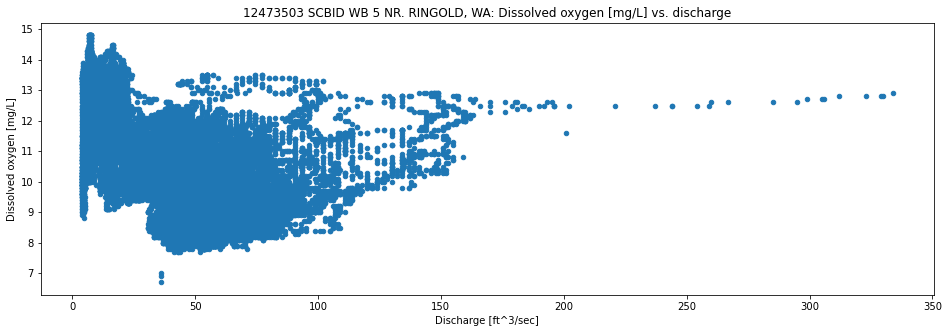

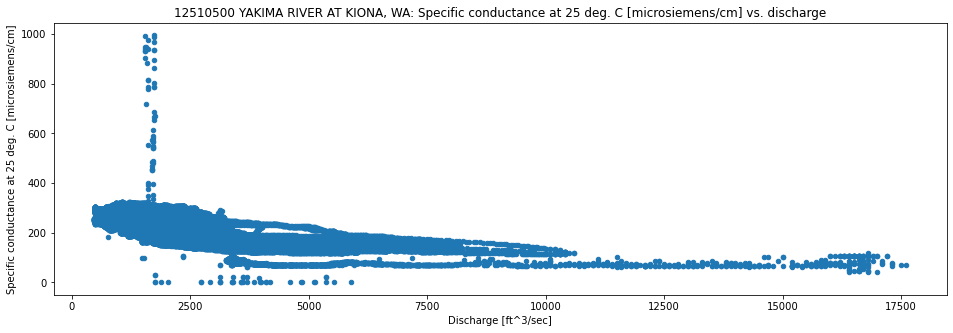

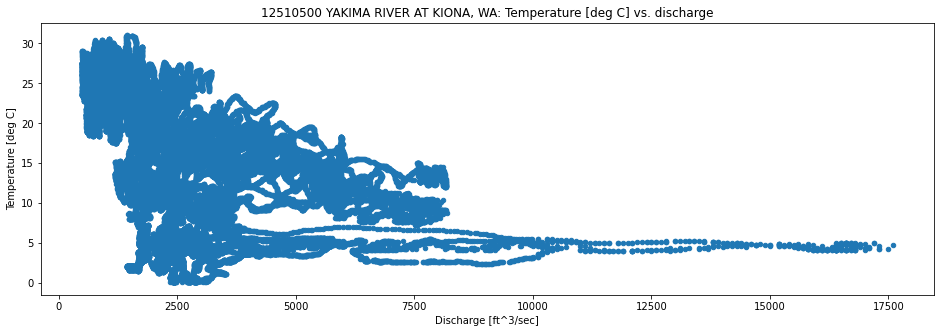

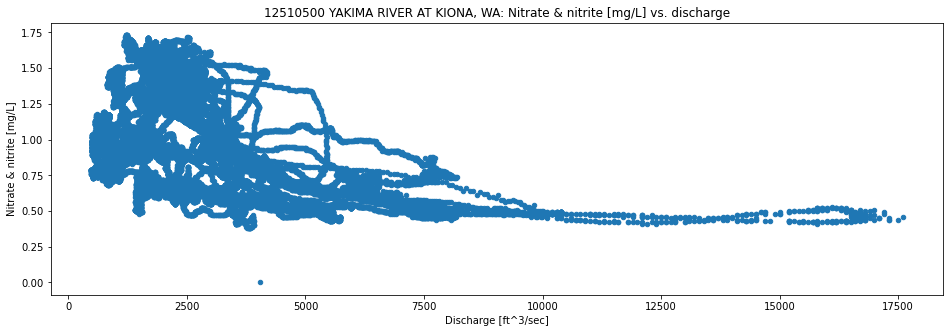

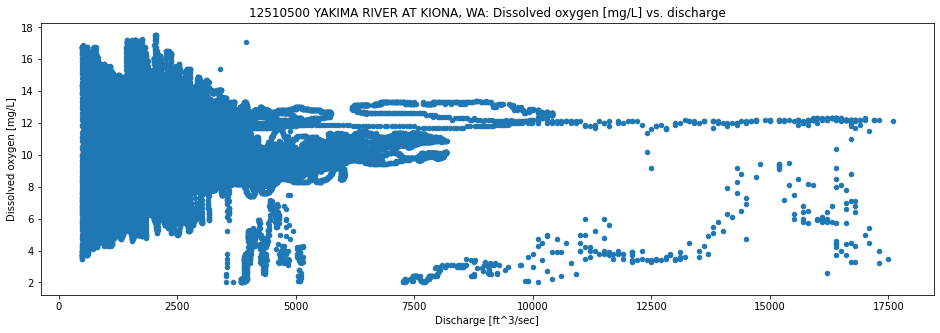

In [138]:
def plotCQ(df, stationName):
    for column in df:
        if column != "Discharge [ft^3/sec]":
            plot = df.plot(x="Discharge [ft^3/sec]", y=column, kind='scatter', figsize=(16,5))
            plot.set_title(stationName + ": " + column + " vs. discharge")

plotCQ(ringold_iv, "12473503 SCBID WB 5 NR. RINGOLD, WA")
plotCQ(kiona_iv, "12510500 YAKIMA RIVER AT KIONA, WA")

In [15]:
m = Map(center=(47,-120), zoom=7)

m.add_layer(Marker(title='SCBID WB 5 WASTEWAY NEAR MOUTH NEAR RINGOLD,WA',location=(46.536522,-119.280069),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='YAKIMA RIVER AT KIONA, WA',location = (46.253467,-119.478079),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='NOAA STATION - ICE HARBOR DAM',location = (46.2447,-118.8786),rise_on_hover = True, draggable = False))

basemap1 = basemap_to_tiles(basemaps.Esri.WorldImagery)
m.add_layer(basemap1)

display(m)

Map(center=[47, -120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Machine Learning Models

In [139]:
df = ringold_iv_final.dropna()
df = df[["Discharge [ft^3/sec]","Temperature [deg C]","Dissolved oxygen [mg/L]"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65025 entries, 2019-04-29 10:15:00-07:00 to 2021-05-01 23:45:00-07:00
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Discharge [ft^3/sec]     65025 non-null  float64
 1   Temperature [deg C]      65025 non-null  float64
 2   Dissolved oxygen [mg/L]  65025 non-null  float64
dtypes: float64(3)
memory usage: 2.0+ MB


In [161]:
y_column = 2
x_data = df.iloc[:, 0:y_column]
y_data = df.iloc[:, y_column:]

array([[<AxesSubplot:title={'center':'Dissolved oxygen [mg/L]'}>]],
      dtype=object)

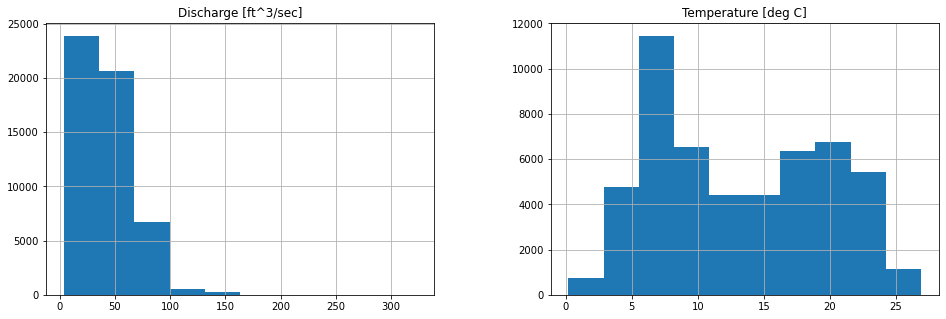

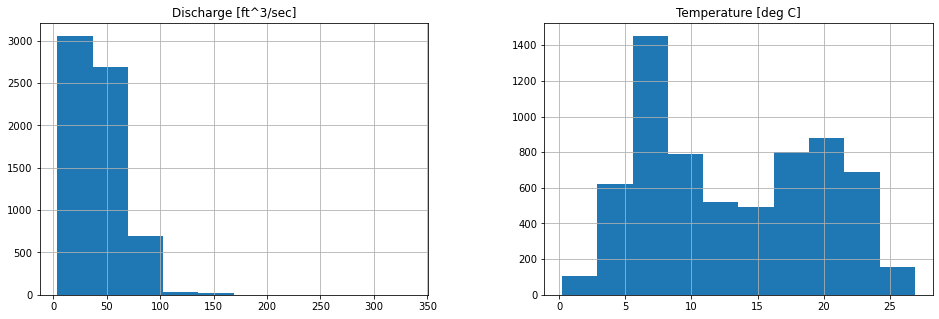

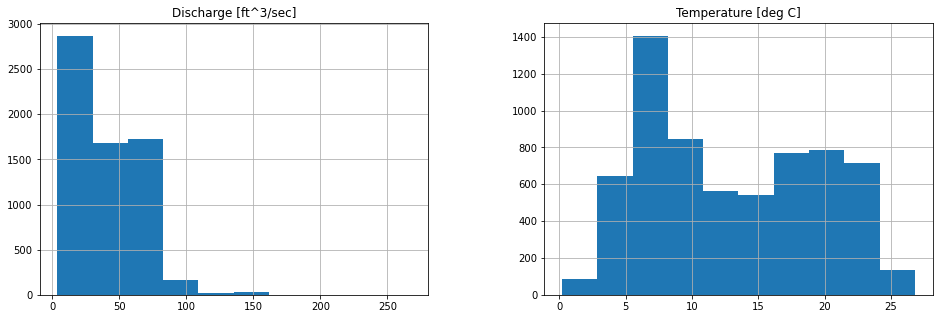

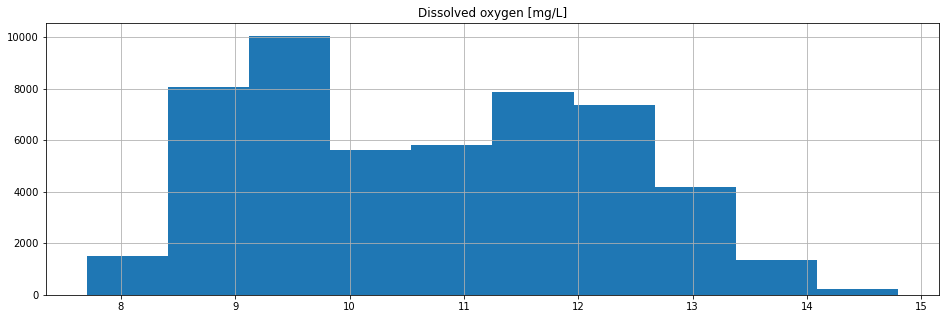

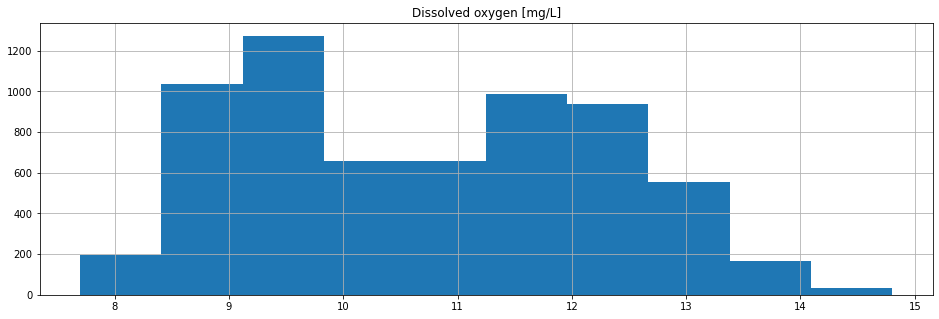

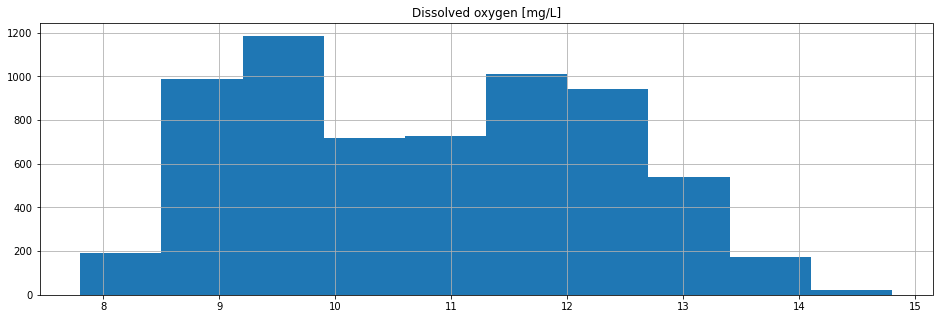

In [214]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)

x_train.hist()
x_test.hist()
x_val.hist()

y_train.hist()
y_test.hist()
y_val.hist()

In [234]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
norm_x_train = x_scaler.fit_transform(x_train)

norm_x_val = x_scaler.transform(x_val)
norm_x_test = x_scaler.transform(x_test)

y_scaler = StandardScaler()
norm_y_train = y_scaler.fit_transform(y_train)

norm_y_val = y_scaler.transform(y_val)
norm_y_test = y_scaler.transform(y_test)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>]], dtype=object)

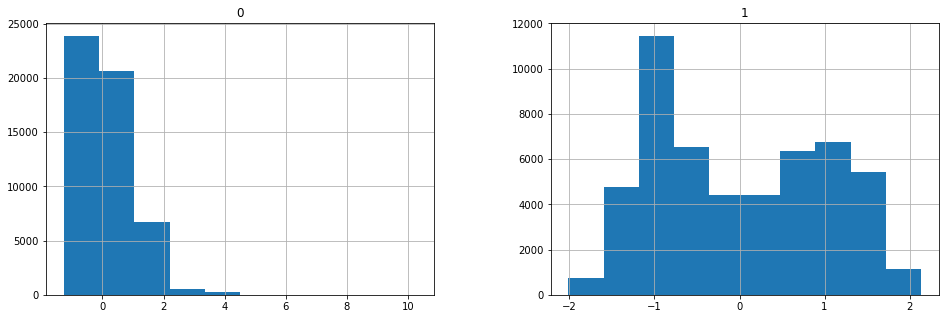

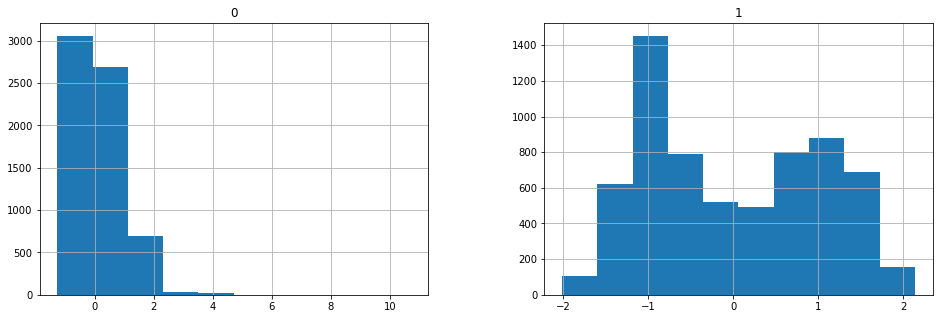

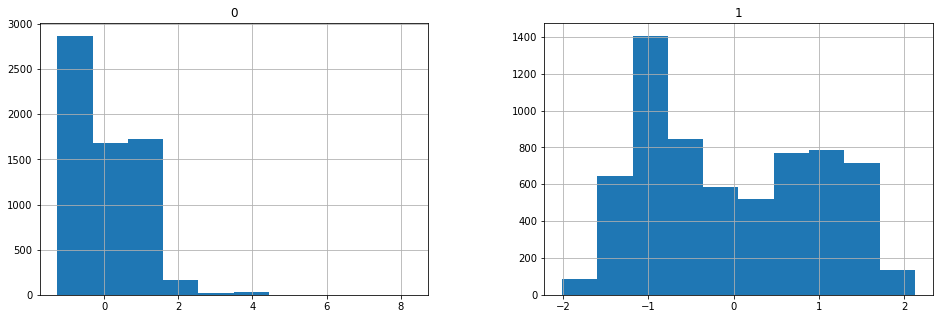

In [235]:
pd.DataFrame(norm_x_train).hist()
pd.DataFrame(norm_x_test).hist()
pd.DataFrame(norm_x_val).hist()

In [236]:
def train(model, x, y, x_val, y_val, lr, epochs):
    # log_dir = "logs/" + model.name + "/"
    
    # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # look into using CSVlogger

    optimizer = tf.optimizers.Adam(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mean_squared_error"]
    )
    
    return model.fit(
        x, 
        y,
        epochs=epochs,
        validation_data=(x_val, y_val),
        # callbacks=[tensorboard_callback],
        verbose=1
    )

In [237]:
simple_model = keras.models.Sequential()
simple_model.add(tf.keras.Input(shape=(2,)))
simple_model.add(tf.keras.layers.Dense(4, activation='relu'))
simple_model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))

simple_history = train(simple_model, norm_x_train, norm_y_train, norm_x_val, norm_y_val, 0.01, 10)

# run multiple times & avg.

Epoch 1/10
1626/1626 [==============================] - 1s 553us/step - loss: 0.0866 - mean_squared_error: 0.0866 - val_loss: 0.0682 - val_mean_squared_error: 0.0682
Epoch 2/10
1626/1626 [==============================] - 1s 462us/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0671 - val_mean_squared_error: 0.0671
Epoch 3/10
1626/1626 [==============================] - 1s 460us/step - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0659 - val_mean_squared_error: 0.0659
Epoch 4/10
1626/1626 [==============================] - 1s 455us/step - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0667 - val_mean_squared_error: 0.0667
Epoch 5/10
1626/1626 [==============================] - 1s 456us/step - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0661 - val_mean_squared_error: 0.0661
Epoch 6/10
1626/1626 [==============================] - 1s 454us/step - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0697 - val_mean_squared_error: 0.0697
Epoc

In [238]:
simple_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


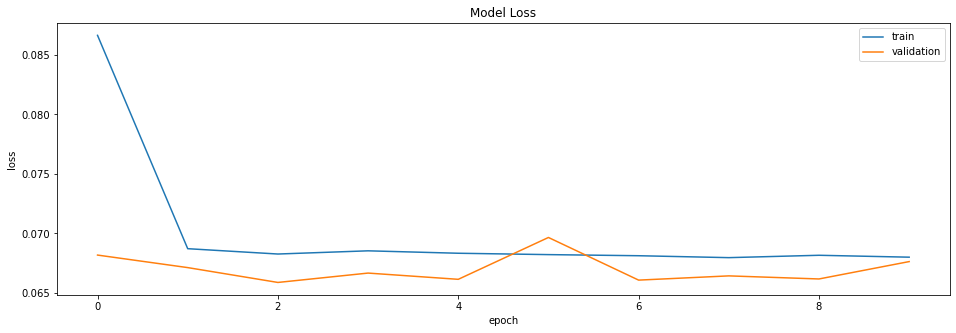

In [239]:
plt.plot(simple_history.history['loss'])
plt.plot(simple_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Text(0.5, 1.0, '12473503 SCBID WB 5 NR. RINGOLD, WA: Predicted vs. actual DO concentration')

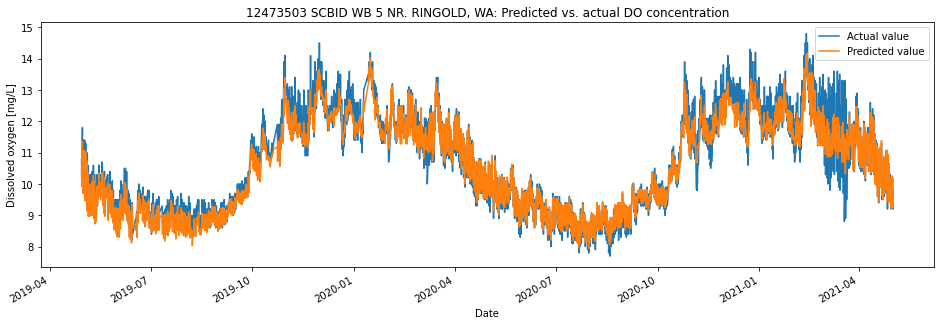

In [255]:
plt.rcParams["figure.figsize"] = (16,5)

predict_test = simple_model.predict(norm_x_test)
predict_values = y_scaler.inverse_transform(predict_test)

final_df = copy.deepcopy(y_test)
final_df['Dissolved oxygen [mg/L]'] = predict_values
final_df.rename(columns = {'Dissolved oxygen [mg/L]':'Predicted value'}, inplace = True)

ax = y_test.rename(columns = {'Dissolved oxygen [mg/L]':'Actual value'}).plot()
final_df.plot(ax = ax, xlabel = 'Date')

ax.set_xlabel('Date')
ax.set_ylabel('Dissolved oxygen [mg/L]')
ax.set_title("12473503 SCBID WB 5 NR. RINGOLD, WA: Predicted vs. actual DO concentration")

In [256]:
simple_model.save('simple_model2_3layer_6node.h5')

In [242]:
# build LSTM (features in 2d array)
# turn off shuffle

- distribution and timeseries plot before and after transformer
- simple hyperparameter search (leaky relu, dropout, #node, epochs, and lr)
- put presentation together
- add random seed

- run 10 models on different seeds & avg.
- model.plot()
- training val and test plots + save to file
- lstm (correct input shape)

- fix NN today